In [283]:
import numpy as np
import pandas as pd
import os
import yfinance as yf

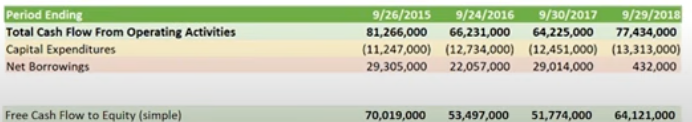

In [382]:
tick = "AMZN"

In [383]:
i = yf.Ticker(tick).info

b = yf.Ticker(tick).balance_sheet
b = b[b.columns[::-1]]
b.columns = pd.DatetimeIndex(b.columns).year

c = yf.Ticker(tick).cashflow
c = c[c.columns[::-1]]
c.columns = pd.DatetimeIndex(c.columns).year

f = yf.Ticker(tick).financials
f = f[f.columns[::-1]]
f.columns = pd.DatetimeIndex(f.columns).year

a = yf.Ticker(tick).analysis["Growth"].to_frame().T

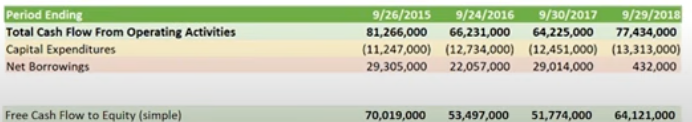

In [384]:
CPO = c.loc["Total Cash From Operating Activities"].to_frame().T
CPO

,2018,2019,2020,2021
Total Cash From Operating Activities,3.072300e+10,3.851400e+10,6.606400e+10,4.632700e+10


In [385]:
CAPEX = c.loc["Capital Expenditures"].to_frame().T
CAPEX

,2018,2019,2020,2021
Capital Expenditures,-1.342700e+10,-1.686100e+10,-4.014000e+10,-6.105300e+10


In [386]:
FCF = (CPO.iloc[0] + CAPEX.iloc[0]).to_frame().T
FCF.index = ["Free Cashflow"]
FCF

,2018,2019,2020,2021
Free Cashflow,1.729600e+10,2.165300e+10,2.592400e+10,-1.472600e+10


In [387]:
net_income = c.loc["Net Income"].to_frame().T
net_income

,2018,2019,2020,2021
Net Income,1.007300e+10,1.158800e+10,2.133100e+10,3.336400e+10


In [388]:
FFCE_net_income = round((FCF.iloc[0] / net_income.iloc[0]) * 100).to_frame().T
FFCE_net_income

,2018,2019,2020,2021
0,172.0,187.0,122.0,-44.0


In [389]:
median_FFCE = FFCE_net_income.iloc[0].median()
median_FFCE

147.0

In [390]:
total_revenue = f.loc["Total Revenue"].to_frame().T
total_revenue

,2018,2019,2020,2021
Total Revenue,2.32887e+11,2.80522e+11,3.86064e+11,4.69822e+11


In [391]:
growths = []
for year1, year2 in zip(total_revenue, total_revenue.iloc[:, 1:]):
    y1 = total_revenue[year1].iloc[0]
    y2 = total_revenue[year2].iloc[0]
    print(y1, y2)
    growth = round((y2 - y1)/y1*100, 2)
    growths.append(growth)
    print(year2, growth)

232887000000.0 280522000000.0
2019 20.45
280522000000.0 386064000000.0
2020 37.62
386064000000.0 469822000000.0
2021 21.7


In [392]:
growths.append(a["0Y"].iloc[0]*100)
growths.append(a["+1Y"].iloc[0]*100)
growths

[20.45, 37.62, 21.7, -75.4, 233.6]

In [393]:
median_growth = round(np.median(growths),2 )
median_growth

21.7

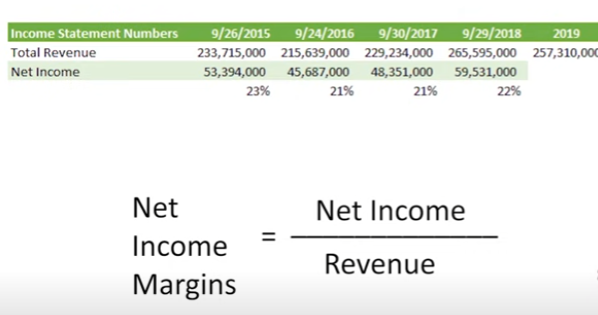

In [394]:
net_income_margins = pd.concat([total_revenue, net_income])
net_income_margins

,2018,2019,2020,2021
Total Revenue,2.32887e+11,2.80522e+11,3.86064e+11,4.69822e+11
Net Income,1.0073e+10,1.1588e+10,2.1331e+10,3.3364e+10


In [395]:
net_income = []
for year in net_income_margins.columns:
    revenue = net_income_margins[year].loc["Total Revenue"]
    netincome = net_income_margins[year].loc["Net Income"]
    net = round(netincome/revenue * 100, 2)
    net_income.append(net)
net_income_margins.loc["Net Income Margins"] = net_income
net_income_margins

,2018,2019,2020,2021
Total Revenue,2.32887e+11,2.80522e+11,3.86064e+11,4.69822e+11
Net Income,1.0073e+10,1.1588e+10,2.1331e+10,3.3364e+10
Net Income Margins,4.33,4.13,5.53,7.1


In [396]:
free_cashflow_rate_median = net_income_margins.loc["Net Income Margins"].median()
free_cashflow_rate_median, median_FFCE

(4.93, 147.0)

In [397]:
income_tatement_numbers = net_income_margins.copy()
income_tatement_numbers = net_income_margins.drop(index="Net Income Margins", axis=0)
income_tatement_numbers = income_tatement_numbers.append(FCF)
income_tatement_numbers

,2018,2019,2020,2021
Total Revenue,2.32887e+11,2.80522e+11,3.86064e+11,4.69822e+11
Net Income,1.0073e+10,1.1588e+10,2.1331e+10,3.3364e+10
Free Cashflow,1.7296e+10,2.1653e+10,2.5924e+10,-1.4726e+10


In [398]:
import datetime
current_year = datetime.datetime.now().year
years_forward = 4

for y in range(current_year, current_year+years_forward):
    rev = income_tatement_numbers[y-1].loc["Total Revenue"] * (1+ (median_growth/ 100))
    n = rev * free_cashflow_rate_median / 100
    fcf = n * median_FFCE / 100
    income_tatement_numbers[y] = [rev, n, fcf]
    
income_tatement_numbers

,2018,2019,2020,2021,2022,2023,2024,2025
Total Revenue,2.32887e+11,2.80522e+11,3.86064e+11,4.69822e+11,5.717734e+11,6.958482e+11,8.468473e+11,1.030613e+12
Net Income,1.0073e+10,1.1588e+10,2.1331e+10,3.3364e+10,2.818843e+10,3.430532e+10,4.174957e+10,5.080923e+10
Free Cashflow,1.7296e+10,2.1653e+10,2.5924e+10,-1.4726e+10,4.143699e+10,5.042881e+10,6.137187e+10,7.468956e+10


## Calculate WACC
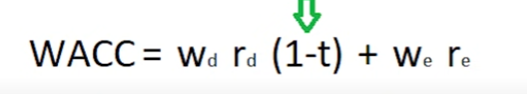

In [399]:
t = f[current_year-1].loc["Income Tax Expense"]/f[current_year-1].loc["Income Before Tax"]
t = round(t, 4)
t

0.1256

In [400]:
rd = (round(abs(f[current_year-1].loc["Interest Expense"])*100 / 
             (b[current_year-1].loc["Short Long Term Debt"]+b[current_year-1].loc["Long Term Debt"]),2))
rd

3.19

In [401]:
rd_ = round(rd*(1-t), 2)
rd_

2.79

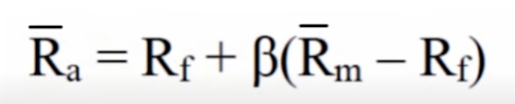

In [402]:
import requests
from bs4 import BeautifulSoup as soup

page = requests.get("https://finance.yahoo.com/bonds")
content = soup(page.content, "html.parser")

In [403]:
Rf = float(content.find("fin-streamer", {"data-symbol":"^TNX"}).text)
Rf

3.044

In [404]:
B = i["beta"]
B

1.119607

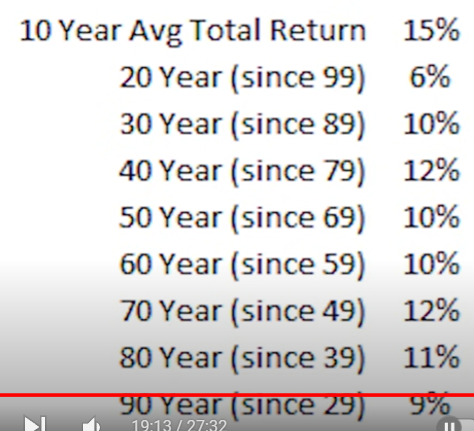

In [405]:
Rm = 10
Rm

10

In [406]:
Ra = Rf + B*(Rm - Rf)
re = Ra
re

10.831986292

In [407]:
total = i["totalDebt"] + i["marketCap"]
wd = i["totalDebt"]*100/total
we = i["marketCap"]*100/total
wd, we

(65.79100133399557, 34.208998666004426)

In [408]:
WACC = round((wd*rd_ + we*re)/100,2)
required_return = WACC
r = required_return/100
required_return

5.54

In [409]:
shares_outstanding = i["sharesOutstanding"]
shares_outstanding

507148000

In [410]:
perpetual_growth = 2.5
g = perpetual_growth / 100

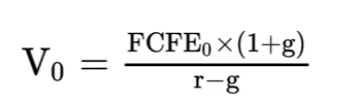

In [411]:
FCFE0 = income_tatement_numbers[current_year+years_forward-1].loc["Free Cashflow"]
terminal_value = (FCFE0*(1+g))/(r-g)
terminal_value = round(terminal_value)
terminal_value

2518315844995

In [412]:
cols_to_drop = list(filter(lambda x: x < current_year, income_tatement_numbers.columns))
cols_to_drop

[2018, 2019, 2020, 2021]

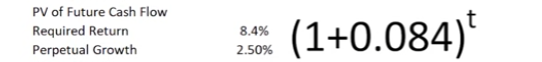

In [413]:
discount_factors = income_tatement_numbers.loc["Free Cashflow"].to_frame().T.drop(cols_to_drop, axis=1)
discount_factors

,2022,2023,2024,2025
Free Cashflow,4.1437e+10,5.04288e+10,6.13719e+10,7.46896e+10


In [414]:
discount_facs = []
discount_val = []
for (j, year) in enumerate(discount_factors.columns):
    discount = (1 + r)**(j+1)
    cashflow = discount_factors[year].loc["Free Cashflow"]
    discount_facs.append(discount)
    discount_val.append(cashflow/discount)
    
discount_factors.loc["Discount Factor"] = discount_facs
discount_factors.loc["PV of Future Cash Flow"] = discount_val
discount_factors

,2022,2023,2024,2025
Free Cashflow,4.1437e+10,5.04288e+10,6.13719e+10,7.46896e+10
Discount Factor,1.0554,1.11387,1.17558,1.2407
PV of Future Cash Flow,3.92619e+10,4.52736e+10,5.22057e+10,6.01993e+10


In [415]:
PV_of_terminal_value = terminal_value * discount_facs[-1]
PV_of_terminal_value

3124485815406.914

In [416]:
todays_value = discount_factors.loc["PV of Future Cash Flow"].sum() + PV_of_terminal_value
todays_value

3321426282061.8843

In [417]:
shares_outstanding

507148000

In [418]:
fair_value_of_equity = todays_value/shares_outstanding
fair_value_of_equity

6549.2248457292235